In [ ]:
# Run this cell first
!pip install -q segmentation-models seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.9 MB/s eta 0:00:00


In [ ]:
# --- 1. SETUP ---
# Install necessary libraries
!pip install -q segmentation-models seaborn scikit-learn

# Set up environment and import libraries
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import segmentation_models as sm
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Define paths and constants
base_dir = '/content/drive/MyDrive/AI_Projects/'
test_image_dir = os.path.join(base_dir, 'test/images/')
test_mask_dir = os.path.join(base_dir, 'test/masks/')
BATCH_SIZE = 16
BACKBONE = 'resnet34'

# --- 2. LOAD DATA AND MODEL ---
# Data pipeline functions (load_and_preprocess, create_dataset)
preprocess_input = sm.get_preprocessing(BACKBONE)
def load_and_preprocess(image_path, mask_path, size=(256, 256)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size)
    image = preprocess_input(image)
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, size)
    mask = tf.cast(mask > 0, tf.float32)
    return image, mask

def create_dataset(image_dir, mask_dir, batch=True):
    image_names = sorted(os.listdir(image_dir))
    image_paths = [os.path.join(image_dir, name) for name in image_names]
    mask_paths = [os.path.join(mask_dir, os.path.splitext(name)[0] + '.png') for name in image_names]
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if batch:
        dataset = dataset.batch(BATCH_SIZE)
    return dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = create_dataset(test_image_dir, test_mask_dir)
print("✅ Test dataset created.")

# Load the saved model
model = sm.Unet(BACKBONE, classes=1, activation='sigmoid')
model_path = '/content/drive/MyDrive/AI_Projects/best_model_final.keras'
model.load_weights(model_path)
print("✅ Best model weights loaded successfully.")

Mounted at /content/drive
✅ Test dataset created.
✅ Best model weights loaded successfully.


Gathering predictions for all test images...
Done.

--- Statistical Report ---
                     precision    recall  f1-score   support

    Water (Class 0)       0.70      0.13      0.22    622123
Oil Spill (Class 1)       0.97      1.00      0.98  16024021

           accuracy                           0.97  16646144
          macro avg       0.83      0.56      0.60  16646144
       weighted avg       0.96      0.97      0.95  16646144



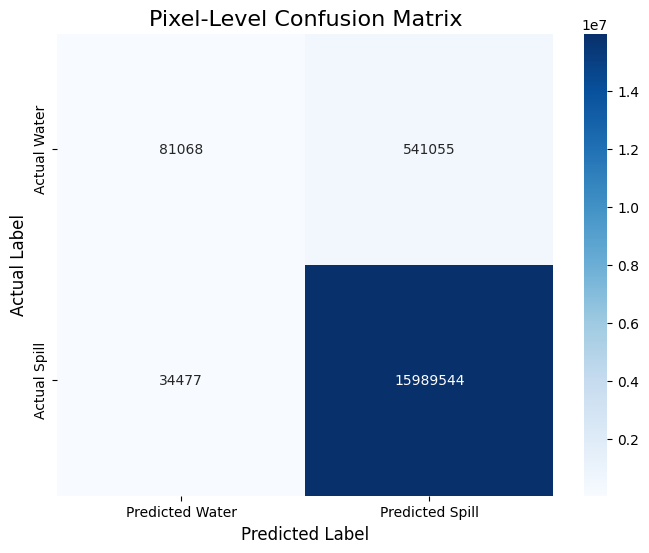

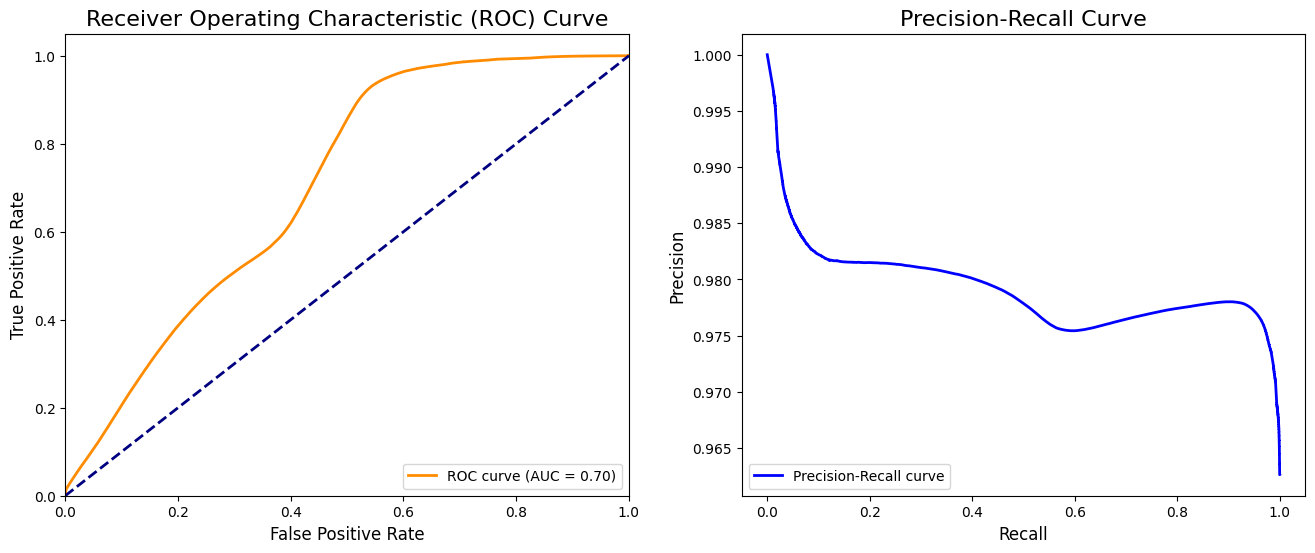

In [ ]:
# --- GATHER PREDICTIONS ---
# We need to iterate through the whole test set once to get all predictions
print("Gathering predictions for all test images...")
y_true_flat = []
y_pred_scores_flat = []
for images, masks in test_dataset:
    preds = model.predict(images, verbose=0)
    y_true_flat.extend(masks.numpy().flatten())
    y_pred_scores_flat.extend(preds.flatten())

y_true_flat = np.array(y_true_flat)
y_pred_flat = (np.array(y_pred_scores_flat) > 0.5).astype(int)
print("Done.")


# --- A. CONFUSION MATRIX & CLASSIFICATION REPORT ---
print("\n--- Statistical Report ---")
print(classification_report(y_true_flat, y_pred_flat, target_names=['Water (Class 0)', 'Oil Spill (Class 1)']))

cm = confusion_matrix(y_true_flat, y_pred_flat)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Water', 'Predicted Spill'],
            yticklabels=['Actual Water', 'Actual Spill'])
plt.title('Pixel-Level Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()


# --- B. ROC CURVE AND PRECISION-RECALL CURVE ---
# Calculate curve data
fpr, tpr, _ = roc_curve(y_true_flat, y_pred_scores_flat)
roc_auc = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(y_true_flat, y_pred_scores_flat)

# Plotting
plt.figure(figsize=(16, 6))
# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=16)
plt.legend(loc="lower left")
plt.show()

Mounted at /content/drive
✅ Test dataset created.
✅ Best model weights loaded successfully.

--- Side-by-Side Comparison ---


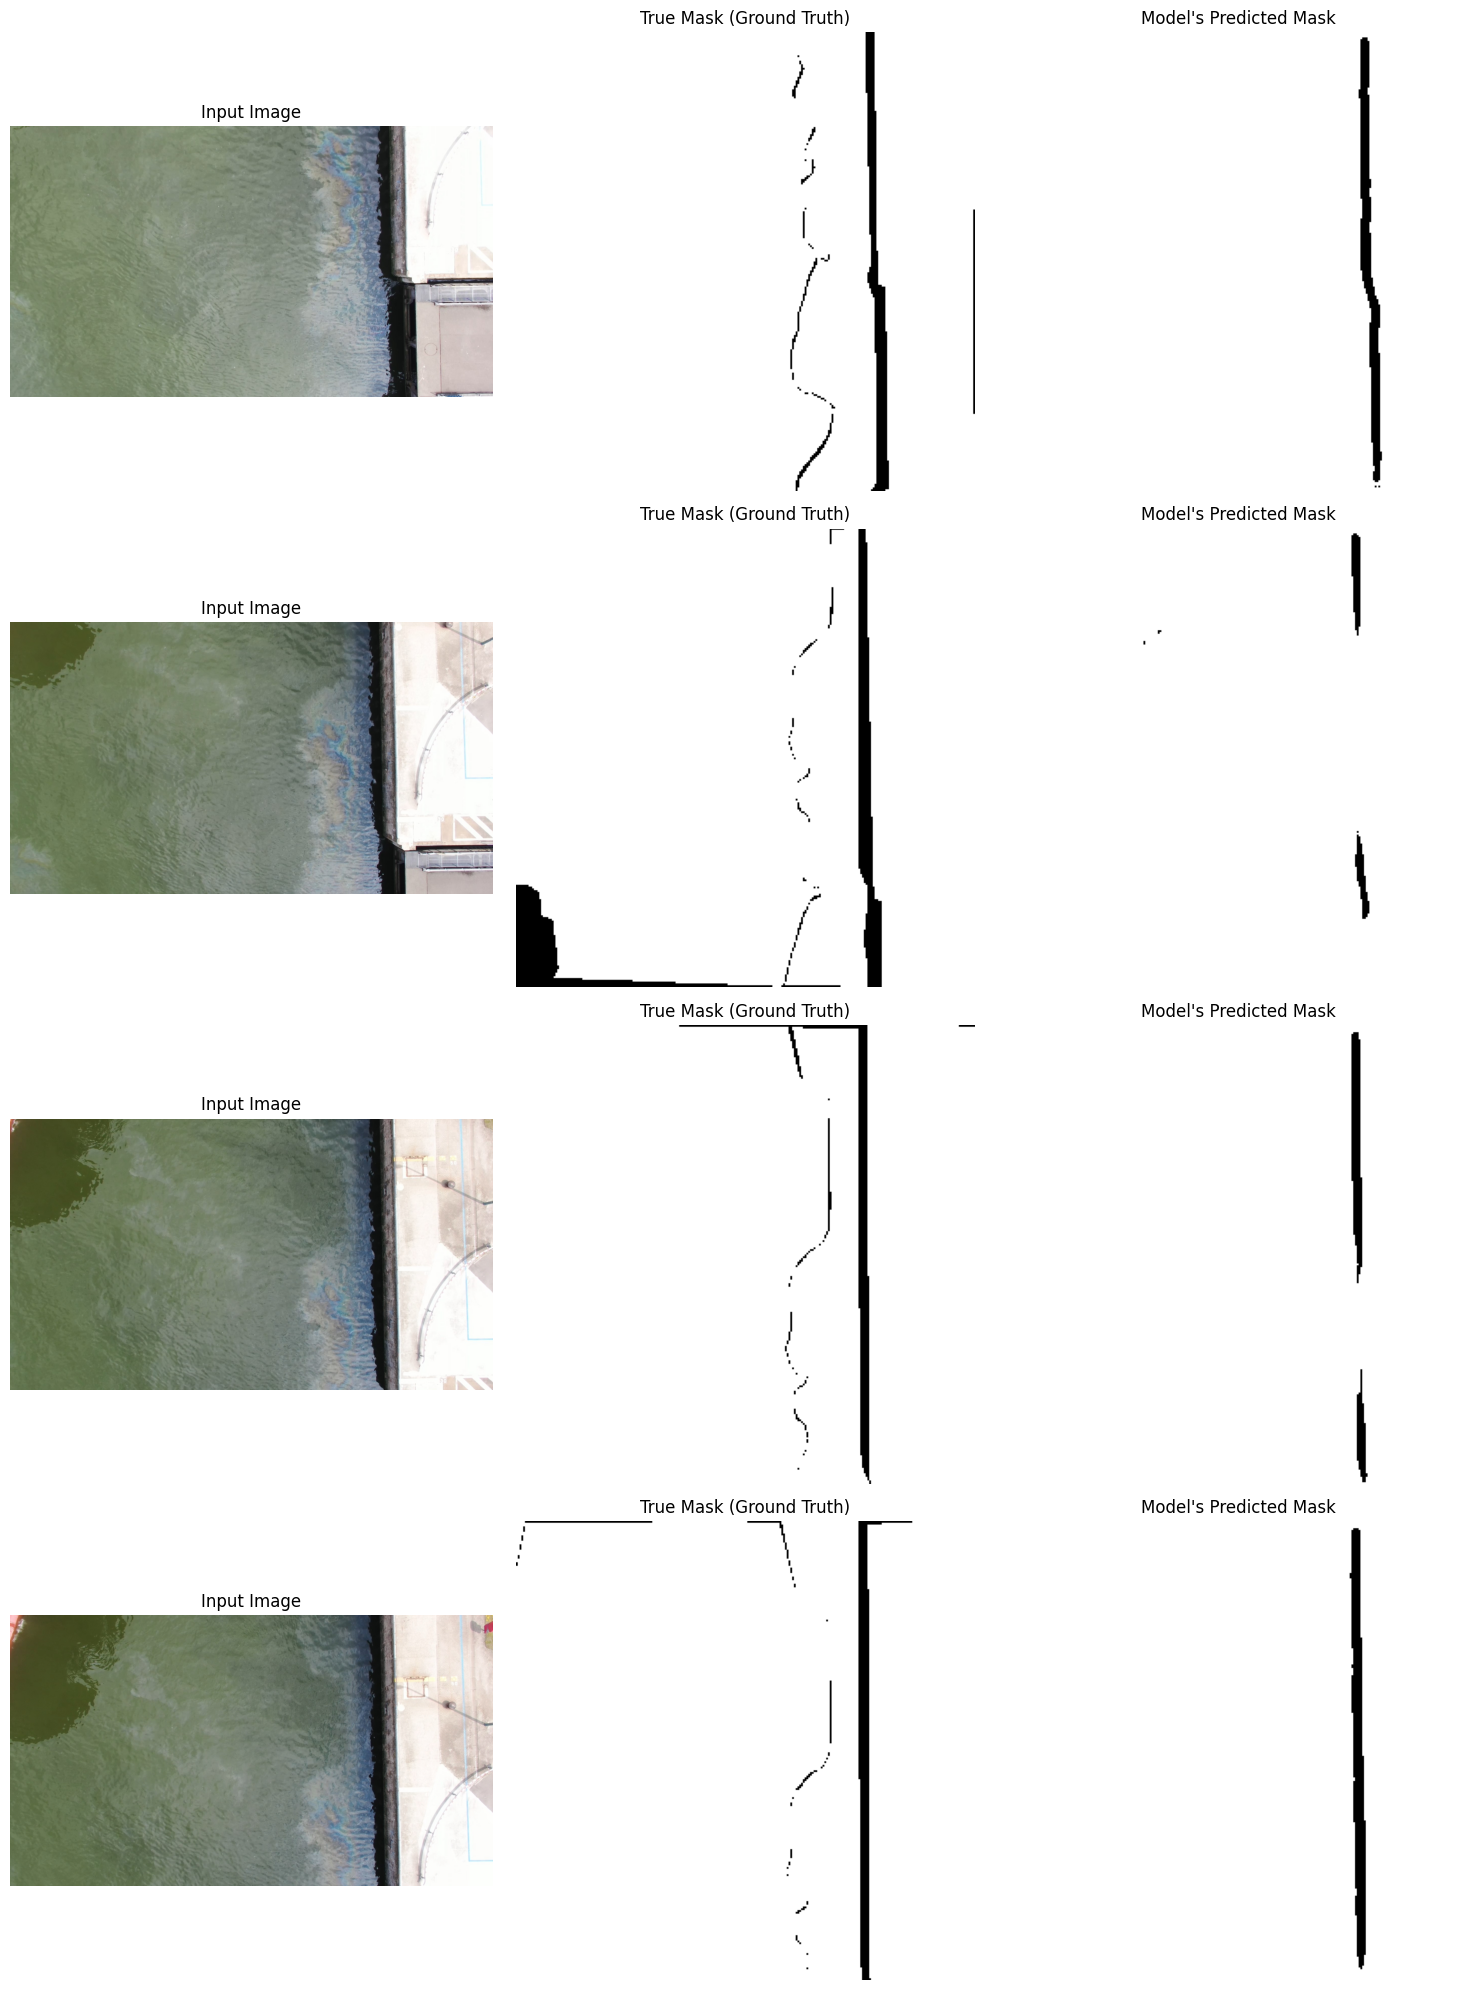


--- Overlay Visualization with Color Masks ---


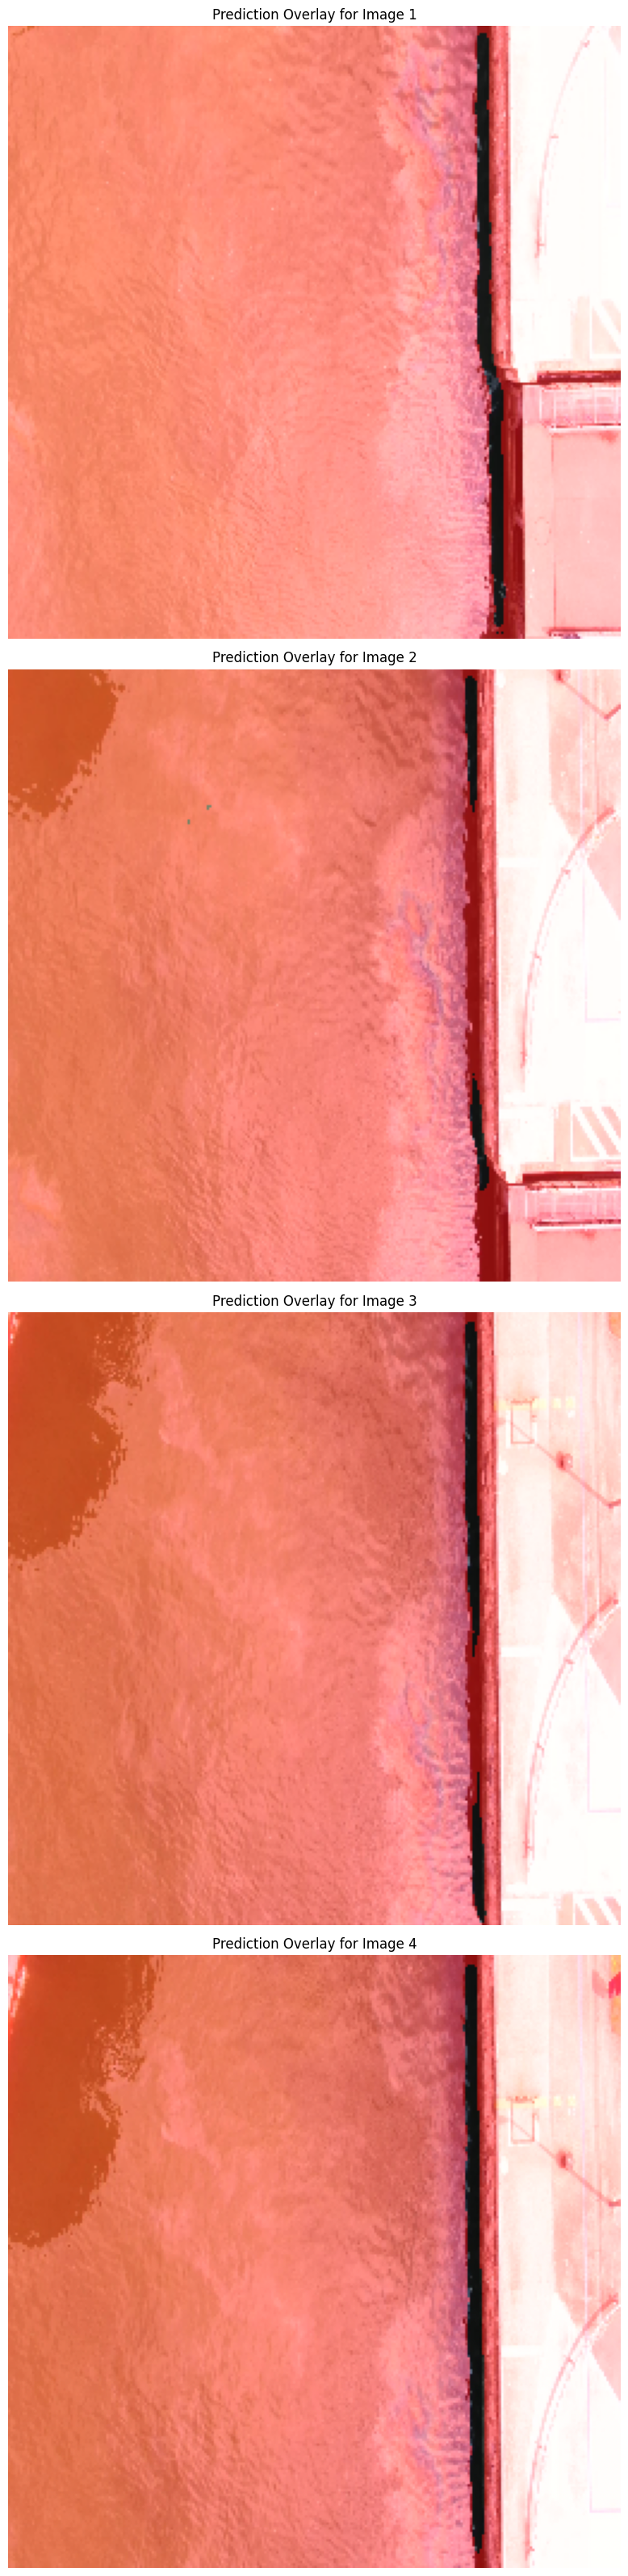

In [ ]:
# --- A: NECESSARY IMPORTS AND SETUP ---
# Run this to prepare your environment
!pip install -q segmentation-models seaborn
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import segmentation_models as sm
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# --- B: LOAD YOUR ASSETS (MODEL AND DATA) ---
# Define paths
base_dir = '/content/drive/MyDrive/AI_Projects/'
test_image_dir = os.path.join(base_dir, 'test/images/')
test_mask_dir = os.path.join(base_dir, 'test/masks/')
BATCH_SIZE = 16
BACKBONE = 'resnet34'

# Define the data pipeline functions
preprocess_input = sm.get_preprocessing(BACKBONE)
def load_and_preprocess(image_path, mask_path, size=(256, 256)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size)
    image.set_shape([size[0], size[1], 3])
    image = preprocess_input(image)
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, size)
    mask.set_shape([size[0], size[1], 1])
    mask = tf.cast(mask > 0, tf.float32)
    return image, mask

def create_dataset(image_dir, mask_dir):
    image_names = sorted(os.listdir(image_dir))
    image_paths = [os.path.join(image_dir, name) for name in image_names]
    mask_paths = [os.path.join(mask_dir, os.path.splitext(name)[0] + '.png') for name in image_names]
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Create the test dataset
test_dataset = create_dataset(test_image_dir, test_mask_dir).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
print("✅ Test dataset created.")

# Rebuild the model architecture and load your saved weights
model = sm.Unet(BACKBONE, classes=1, activation='sigmoid')
model_path = '/content/drive/MyDrive/AI_Projects/best_model_final.keras'
model.load_weights(model_path)
print("✅ Best model weights loaded successfully.")


# --- C: GENERATE THE VISUALIZATIONS ---
# This is the function that generates the side-by-side and overlay plots.

def generate_visual_proof(dataset, image_dir, num_to_display=4):
    """Generates the final visual report with side-by-side and overlay comparisons."""
    test_image_names = sorted(os.listdir(image_dir))

    # Get one batch of images to display
    for image_batch, mask_batch in dataset.take(1):
        # Make predictions on the batch
        predictions = model.predict(image_batch, verbose=0)

        # 1. Side-by-Side Comparison
        print("\n--- Side-by-Side Comparison ---")
        plt.figure(figsize=(15, num_to_display * 5))
        for i in range(num_to_display):
            original_image = plt.imread(os.path.join(image_dir, test_image_names[i]))

            plt.subplot(num_to_display, 3, i * 3 + 1)
            plt.title("Input Image")
            plt.imshow(original_image)
            plt.axis('off')

            plt.subplot(num_to_display, 3, i * 3 + 2)
            plt.title("True Mask (Ground Truth)")
            plt.imshow(tf.squeeze(mask_batch[i]), cmap='gray')
            plt.axis('off')

            plt.subplot(num_to_display, 3, i * 3 + 3)
            plt.title("Model's Predicted Mask")
            plt.imshow(tf.squeeze(predictions[i]) > 0.5, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

        # 2. Overlay Visualization with Color Masks
        print("\n--- Overlay Visualization with Color Masks ---")
        plt.figure(figsize=(8, num_to_display * 8))
        for i in range(num_to_display):
            original_image_cv = cv2.imread(os.path.join(image_dir, test_image_names[i]))
            original_image_cv = cv2.cvtColor(original_image_cv, cv2.COLOR_BGR2RGB)
            original_image_cv = cv2.resize(original_image_cv, (256, 256))

            pred_mask = (tf.squeeze(predictions[i]) > 0.5).numpy().astype('uint8')
            color_mask = np.zeros_like(original_image_cv)
            color_mask[pred_mask == 1] = [255, 0, 0] # Red for oil spills

            # Blend the original image with the red color mask
            overlay = cv2.addWeighted(original_image_cv, 1, color_mask, 0.5, 0)

            plt.subplot(num_to_display, 1, i + 1)
            plt.imshow(overlay)
            plt.title(f"Prediction Overlay for Image {i+1}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

# Run the visualization function
generate_visual_proof(test_dataset, test_image_dir)

--- Analyzing individual image performance to find best and worst cases ---

--- Worst Performing Cases (Lowest IoU) ---


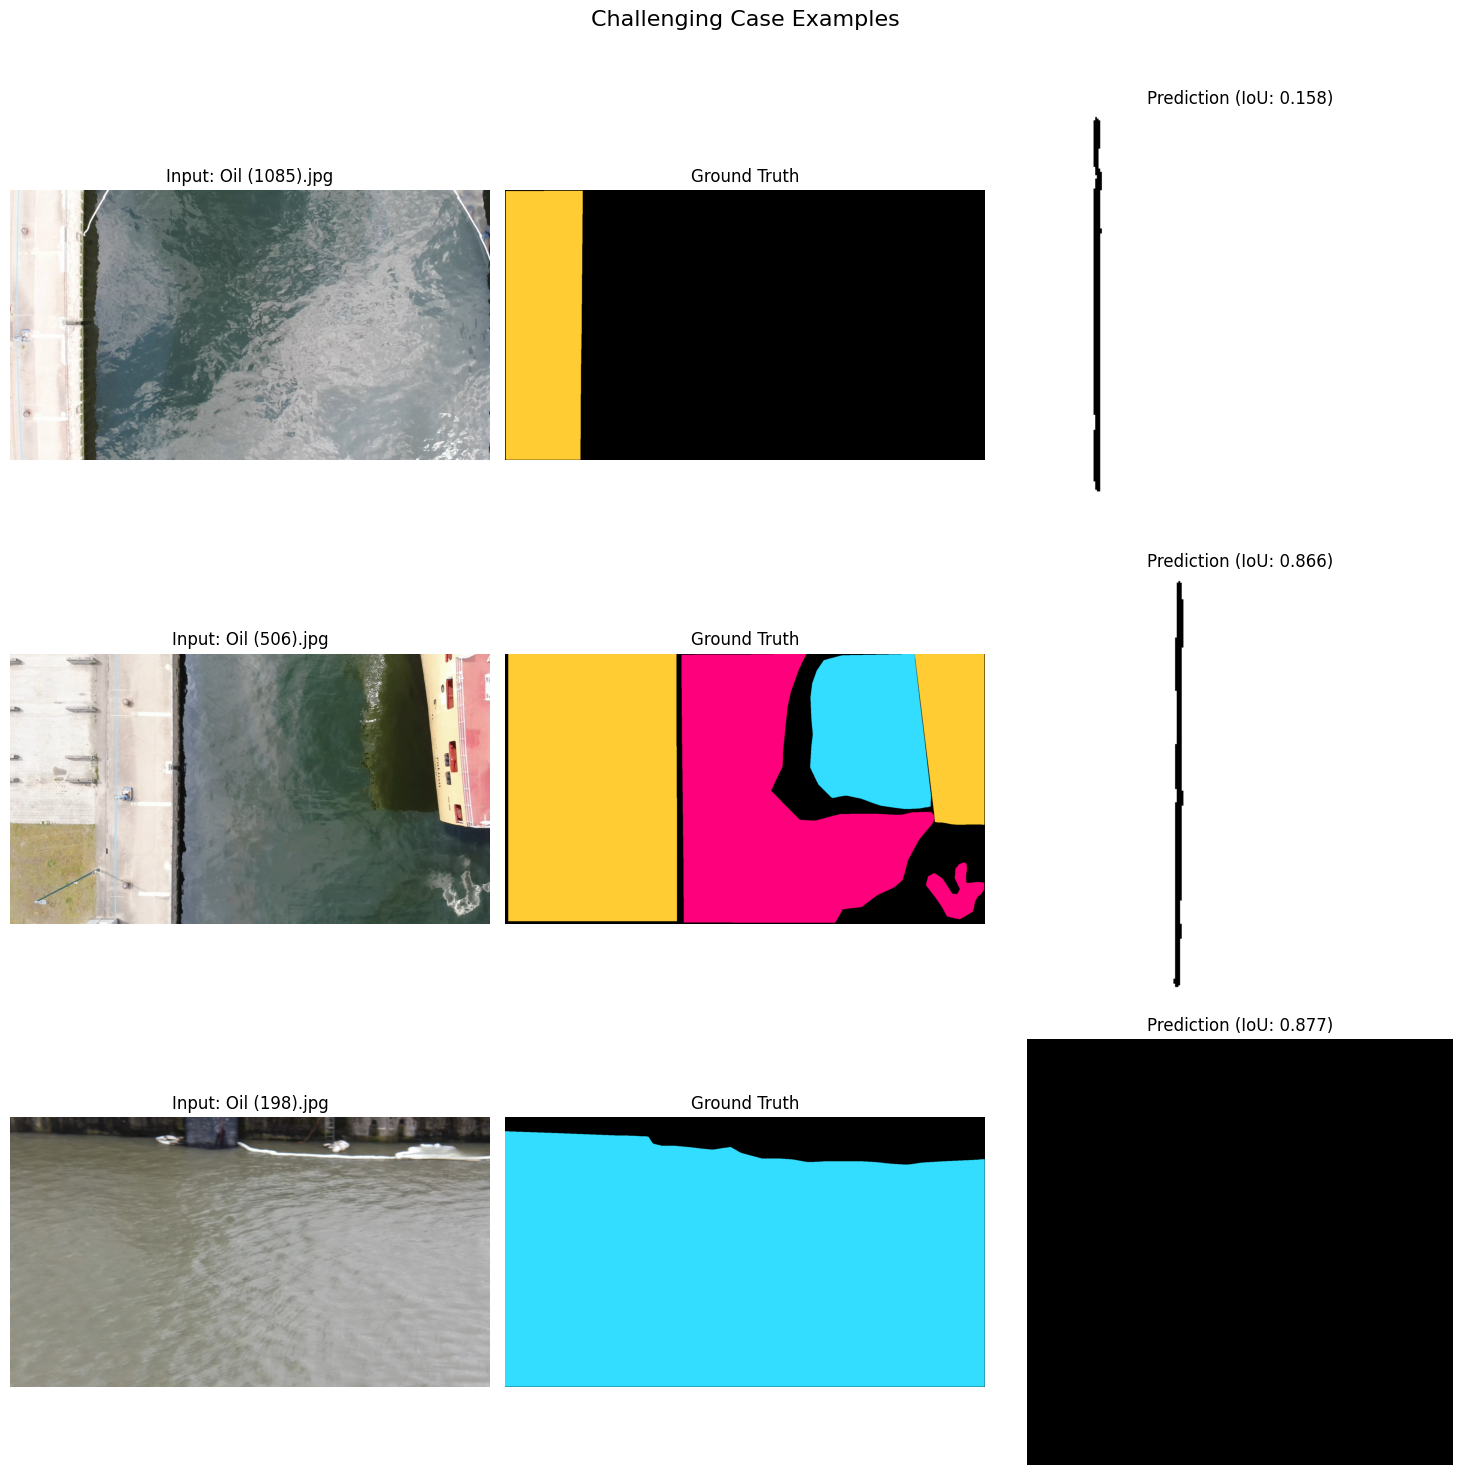


--- Best Performing Cases (Highest IoU) ---


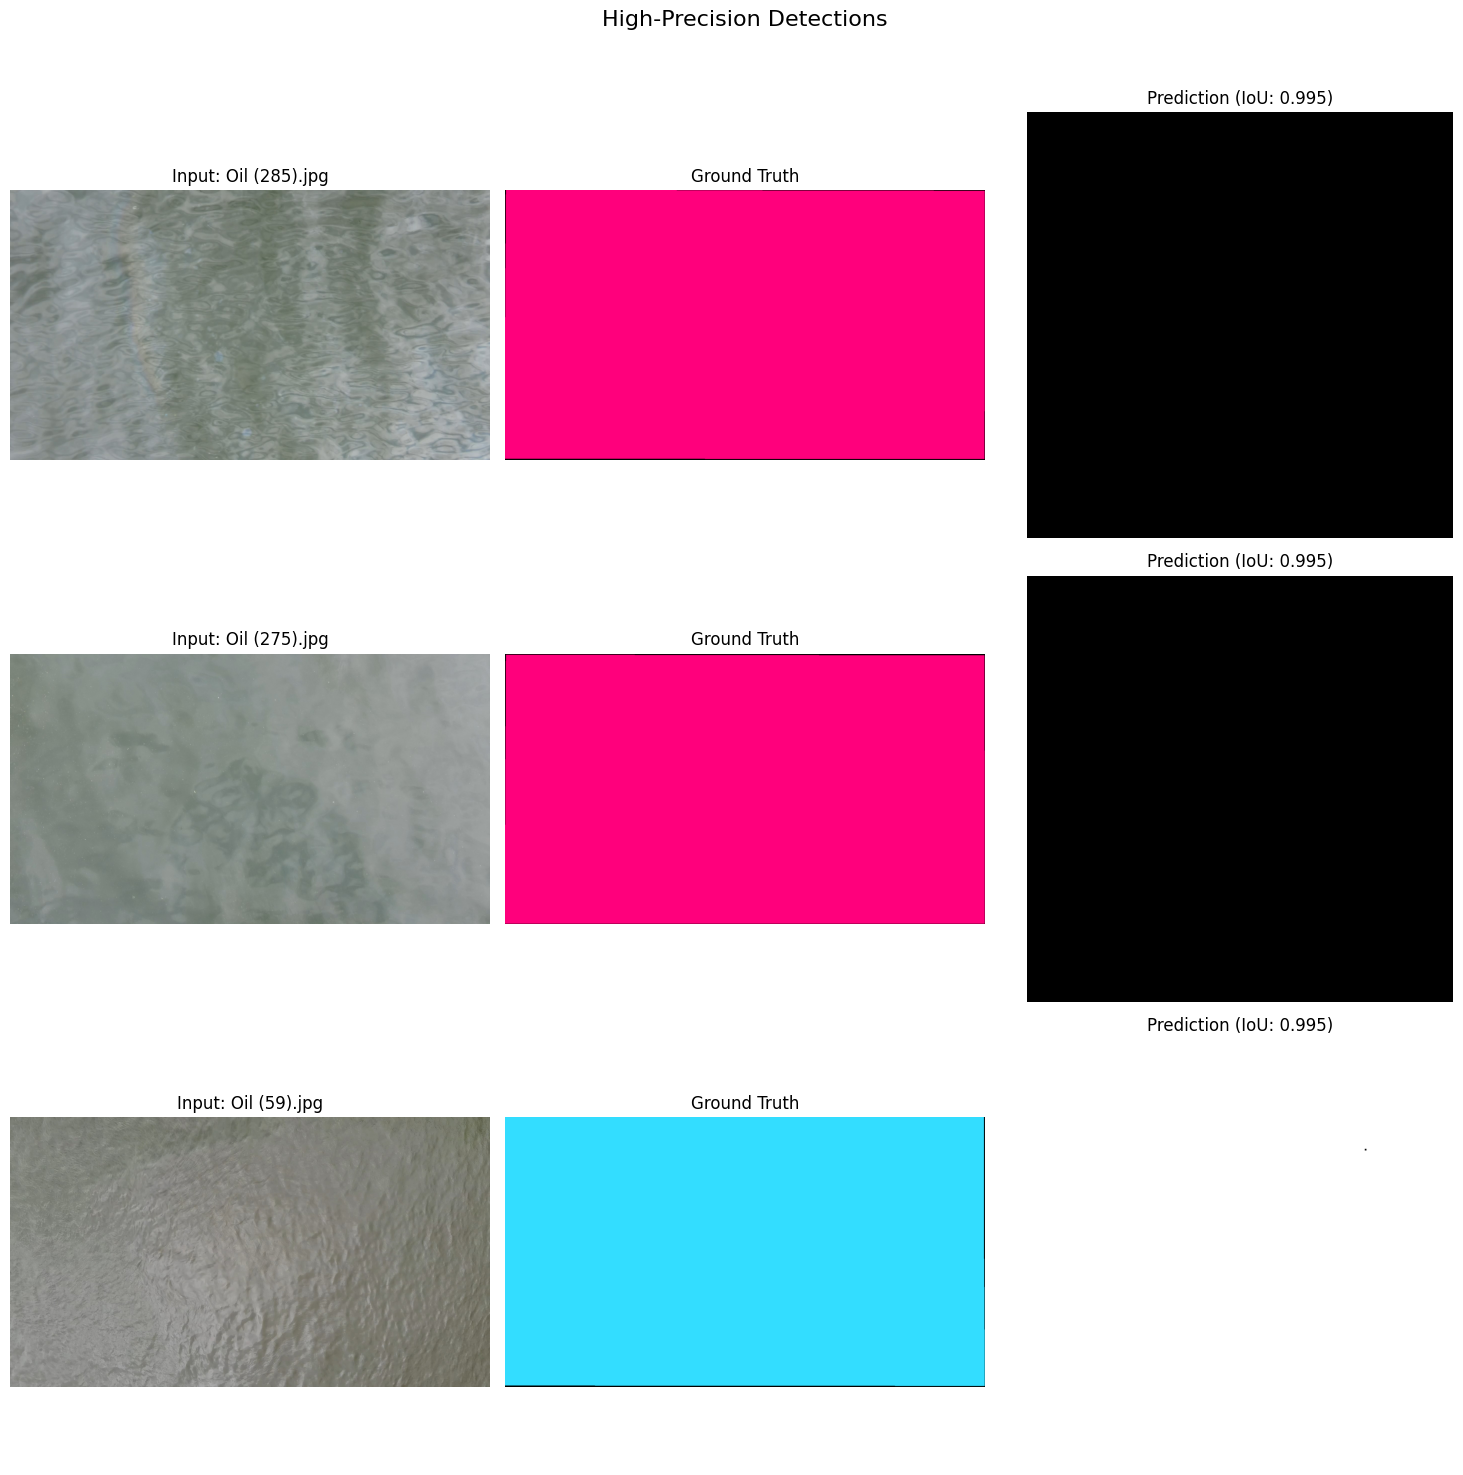

In [ ]:
import segmentation_models as sm
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

# --- This is the corrected create_dataset function ---
def create_dataset(image_dir, mask_dir, batch=True):
    """
    Creates a tf.data.Dataset. If batch=False, it yields individual images.
    """
    image_names = sorted(os.listdir(image_dir))
    image_paths = [os.path.join(image_dir, name) for name in image_names]
    mask_paths = [os.path.join(mask_dir, os.path.splitext(name)[0] + '.png') for name in image_names]
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    # We assume load_and_preprocess is defined from the previous script
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    if batch:
        dataset = dataset.batch(BATCH_SIZE)

    return dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
# ----------------------------------------------------


print("--- Analyzing individual image performance to find best and worst cases ---")

# Create the unbatched dataset using the corrected function
test_dataset_unbatched = create_dataset(test_image_dir, test_mask_dir, batch=False)
test_image_names = sorted(os.listdir(test_image_dir))

iou_metric = sm.metrics.IOUScore()
results = []

# Loop through every image in the test set
for i, (processed_image, true_mask) in enumerate(test_dataset_unbatched):
    input_tensor = tf.expand_dims(processed_image, axis=0)
    true_mask_tensor = tf.expand_dims(true_mask, axis=0)

    pred_mask = model.predict(input_tensor, verbose=0)

    iou = iou_metric(true_mask_tensor, pred_mask).numpy()

    results.append({
        'index': i,
        'iou': iou,
        'image_name': test_image_names[i],
        'prediction': tf.squeeze(pred_mask)
    })

# Sort the results from worst to best
sorted_results = sorted(results, key=lambda x: x['iou'])

def display_cases(cases, title, image_dir, mask_dir):
    """Helper function to display the best/worst cases."""
    plt.figure(figsize=(15, len(cases) * 5))
    plt.suptitle(title, fontsize=16)
    for i, case in enumerate(cases):
        original_image = plt.imread(os.path.join(image_dir, case['image_name']))
        true_mask_img = plt.imread(os.path.join(mask_dir, os.path.splitext(case['image_name'])[0] + '.png'))

        plt.subplot(len(cases), 3, i * 3 + 1)
        plt.imshow(original_image)
        plt.title(f"Input: {case['image_name']}")
        plt.axis('off')

        plt.subplot(len(cases), 3, i * 3 + 2)
        plt.imshow(true_mask_img, cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(len(cases), 3, i * 3 + 3)
        plt.imshow(case['prediction'] > 0.5, cmap='gray')
        plt.title(f"Prediction (IoU: {case['iou']:.3f})")
        plt.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- Display the final results ---
print("\n--- Worst Performing Cases (Lowest IoU) ---")
display_cases(sorted_results[:3], "Challenging Case Examples", test_image_dir, test_mask_dir)

print("\n--- Best Performing Cases (Highest IoU) ---")
display_cases(sorted_results[-3:], "High-Precision Detections", test_image_dir, test_mask_dir)